In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

In [3]:
sample_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61571 entries, 0 to 61570
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          61571 non-null  object 
 1   cid           61571 non-null  float64
 2   transactions  61571 non-null  int64  
 3   revenue       61571 non-null  int64  
 4   group         61571 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ MB


In [4]:
sample_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61383 entries, 0 to 61382
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          61383 non-null  object 
 1   cid           61383 non-null  float64
 2   transactions  61383 non-null  int64  
 3   revenue       61383 non-null  int64  
 4   group         61383 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ MB


In [6]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

In [21]:
daily_a = sample_a.groupby('date').agg({'cid':'count','transactions':'sum', 'revenue':'sum'}).reset_index()

In [23]:
daily_b = sample_b.groupby('date').agg({'cid':'count','transactions':'sum', 'revenue':'sum'}).reset_index()

In [22]:
daily_a[daily_a['date'] == '2020-11-08']

,date,cid,transactions,revenue
2,2020-11-08,3354,25,846051


In [24]:
daily_a['conversion'] = daily_a['transactions']/daily_a['cid']*100

In [26]:
daily_b['conversion'] = daily_b['transactions']/daily_b['cid']*100

In [29]:
display(daily_a['conversion'].mean(), daily_a['conversion'].median())
display(daily_b['conversion'].mean(), daily_b['conversion'].median())

0.7230245916988357

0.7205378188342302

0.7625621195685196

0.7223869647093937

In [31]:
daily_a.loc[:, 'cum_cid'] = daily_a['cid'].cumsum()
daily_a.loc[:, 'cum_transactions'] = daily_a['transactions'].cumsum()
daily_a.loc[:, 'cum_revenue'] = daily_a['revenue'].cumsum()
daily_a['cum_conversion'] = daily_a['cum_transactions']/daily_a['cum_cid']*100

In [33]:
daily_b.loc[:, 'cum_cid'] = daily_b['cid'].cumsum()
daily_b.loc[:, 'cum_transactions'] = daily_b['transactions'].cumsum()
daily_b.loc[:, 'cum_revenue'] = daily_b['revenue'].cumsum()
daily_b['cum_conversion'] = daily_b['cum_transactions']/daily_b['cum_cid']*100

In [36]:
round(daily_a['cum_conversion'].mean(),2)

0.71

In [37]:
round(daily_b['cum_conversion'].mean(),2)

0.76

<Axes:xlabel='date', ylabel='cum_conversion'>

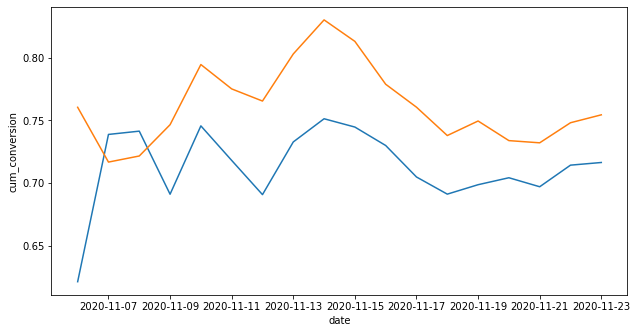

In [48]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])

sns.lineplot(data=daily_a, x='date', y='cum_conversion', ax=ax)
sns.lineplot(data=daily_b, x='date', y='cum_conversion', ax=ax)


In [49]:
from statsmodels.stats.proportion import proportions_ztest

In [50]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


<AxesSubplot:xlabel='time(B)', ylabel='Count'>

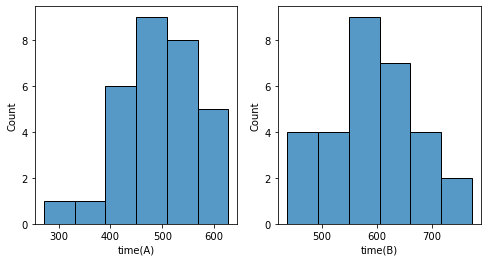

In [55]:
fig,axes = plt.subplots(1,2,figsize=(8,4))

sns.histplot(data=time_data, x='time(A)', ax=axes[0])
sns.histplot(data=time_data, x='time(B)', ax=axes[1])

In [56]:
from scipy.stats import shapiro

In [59]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05
shapiro_a = shapiro(time_data['time(A)'])
shapiro_b = shapiro(time_data['time(B)'])

if shapiro_a.pvalue<alpha or shapiro_b.pvalue<alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


In [60]:
from scipy.stats import ttest_ind

In [61]:
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости

In [64]:
result = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='less'
)

if result.pvalue<alpha:
    print("Отвергаем нулевую гипотезу {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу Среднее время в группах одинаково
Альтернативная гипотеза H1: Среднее время в группе А меньше, чем в группе B


In [67]:
from statsmodels.stats.proportion import proportions_ztest

In [68]:
H0 = 'Конверсия в группе А равна конверсии в группе B.'
H1 = 'Конверсия в группе А меньше, чем конверсия в группе B.'

In [102]:
from scipy.stats import norm
from scipy.stats import t

In [104]:
# Определение доверительного интервала

def conf_z_interval(n, x_mean, std, gamma, rnd=2):
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2)
    print(f'z_crit={round(z_crit,2)}')
    eps = z_crit*std/(n**0.5)
    print('eps={}'.format(round(eps,rnd)))
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return (round(lower_bound, rnd), round(upper_bound, rnd))


def conf_t_interval(n, x_mean, x_std, gamma, rnd=2):
    k = n - 1
    alpha = 1 - gamma
    t_crit = -t.ppf(alpha/2, k)
    print(f't_crit={round(t_crit,2)}')
    eps = t_crit*x_std/(n**0.5)
    print('eps={}'.format(round(eps,rnd)))
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    return (round(lower_bound, rnd), round(upper_bound, rnd))

In [100]:
conf_z_interval(64, 12.35, 2.4, 0.9)

z_crit=1.64
eps=0.49


(11.86, 12.84)

In [105]:
conf_t_interval(25, 3540, 1150, 0.9)

t_crit=1.71
eps=393.5


(3146.5, 3933.5)